# XGBoost Modelling Tuesday

## Stricter delay outlier detection

In [202]:
import pandas as pd

# bring in data
path = '/Users/reneehall/Documents/Learning/lighthouse_labs/coursework-lighthouse-labs/Mid-term project/colab_data/'
fl_df = pd.read_csv(path+'cleaned_flights_sample.csv')

# remove columns that we can't predict ahead of time, including departure delay
to_drop = ['cancellation_code', 'carrier_delay', 'weather_delay', 'nas_delay','security_delay','late_aircraft_delay','first_dep_time','total_add_gtime','longest_add_gtime','cancelled', 'dep_time', 'arr_time', 'actual_elapsed_time']
fl_df = fl_df.drop(labels=to_drop, axis=1)

In [203]:
y = fl_df['arr_delay']
x = 

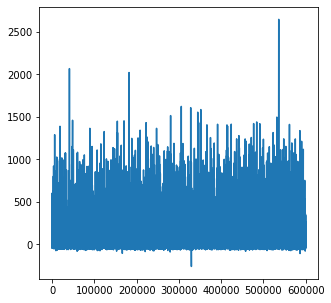

In [205]:
import matplotlib.pyplot as plt

plt.plot(y)
plt.show()

In [4]:
fl_df.columns

Index(['fl_date', 'mkt_unique_carrier', 'branded_code_share', 'mkt_carrier',
       'mkt_carrier_fl_num', 'op_unique_carrier', 'tail_num',
       'op_carrier_fl_num', 'origin_airport_id', 'origin', 'origin_city_name',
       'dest_airport_id', 'dest', 'dest_city_name', 'crs_dep_time',
       'dep_delay', 'taxi_out', 'wheels_off', 'wheels_on', 'taxi_in',
       'crs_arr_time', 'arr_delay', 'diverted', 'dup', 'crs_elapsed_time',
       'air_time', 'flights', 'distance'],
      dtype='object')

In [18]:
# arr_delay
# find 0.95 and 0.05 percentile
import numpy as np

high = np.percentile(fl_df['arr_delay'], q=95.0)
print("95% cutoff", high)
low = np.percentile(fl_df['arr_delay'], q=0.05)
print("5% cutoff", low)

95% cutoff 75.0
5% cutoff -53.0


In [21]:
# dep_delay
# find 0.95 and 0.05 percentile
import numpy as np

high = np.percentile(fl_df['dep_delay'], q=95.0)
print("95% cutoff", high)
low = np.percentile(fl_df['dep_delay'], q=0.05)
print("5% cutoff", low)

95% cutoff 75.0
5% cutoff -23.0


In [22]:
# remove outliers from dataset and check shape
no_out = fl_df.loc[(fl_df['arr_delay'] <= 75)&(fl_df['arr_delay'] >= -53)&(fl_df['dep_delay'] <= 75)&(fl_df['dep_delay'] >= -23)]
no_out.shape

(541258, 28)

In [23]:
def remove_delay_outliers(fl_df):
    no_out = fl_df.loc[(fl_df['arr_delay'] <= 75)&(fl_df['arr_delay'] >= -53)&(fl_df['dep_delay'] <= 75)&(fl_df['dep_delay'] >= -23)]
    return no_out

## XGBoost with outliers gone

In [36]:
import pandas as pd

# bring in data
path = '/Users/reneehall/Documents/Learning/lighthouse_labs/coursework-lighthouse-labs/Mid-term project/colab_data/'
fl_df = pd.read_csv(path+'cleaned_flights_sample.csv')

# remove columns that we can't predict ahead of time, including departure delay
to_drop = ['cancellation_code', 'carrier_delay', 'weather_delay', 'nas_delay','security_delay','late_aircraft_delay','first_dep_time','total_add_gtime','longest_add_gtime','cancelled', 'dep_time', 'arr_time', 'actual_elapsed_time']
fl_df = fl_df.drop(labels=to_drop, axis=1)

fl_df = remove_delay_outliers(fl_df)

In [37]:
# need to transform categorical into continuous

# date string to unix
import datetime as dt 

fl_df['fl_date'] = pd.to_datetime(fl_df['fl_date'])
fl_df['timestamp'] = fl_df['fl_date'].map(dt.datetime.toordinal)
fl_df = fl_df.drop(labels=['fl_date'], axis=1)

# encode categorical vars
from sklearn import preprocessing

label_encoder = preprocessing.LabelEncoder()

cat_vars = fl_df.select_dtypes(include= 'object').columns.tolist()
for col in cat_vars:
    fl_df[col] = label_encoder.fit_transform(fl_df[col])

In [38]:
# separate x and y
X = fl_df.drop(labels=['arr_delay','dep_delay'], axis=1)
y = fl_df['arr_delay']

# make train-test split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, test_size=0.3, random_state=101)

In [39]:
import xgboost as xgb
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_percentage_error

xg = xgb.XGBRegressor()
xg.fit(X_train, y_train)
y_xg = xg.predict(X_test)

# evaluate using MAE
MAE = mean_absolute_error(y_test, y_xg)
print(f"MAE: {MAE}")

# evaluate using R2
R2 = r2_score(y_test, y_xg)
print(f"R2: {R2}")

# evaluate with adjusted R2
adj_R2 = 1 - ((1 - R2)*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1))
print(f"adj_R2: {adj_R2}")

# calculate MAPE
MAPE = mean_absolute_percentage_error(y_test,y_xg)
print(f"MAPE: {MAPE}")

MAE: 14.246088936751073
R2: 0.010211556544929445
adj_R2: 0.010053045051129916
MAPE: 258445662535949.2


#### plot important features

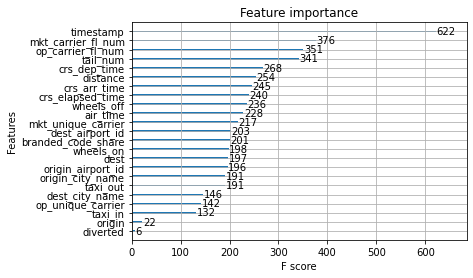

In [41]:
import matplotlib.pyplot as plt

xgb.plot_importance(xg)
plt.rcParams['figure.figsize'] = [5, 5]
plt.show()

#### correlation matrix

<AxesSubplot:>

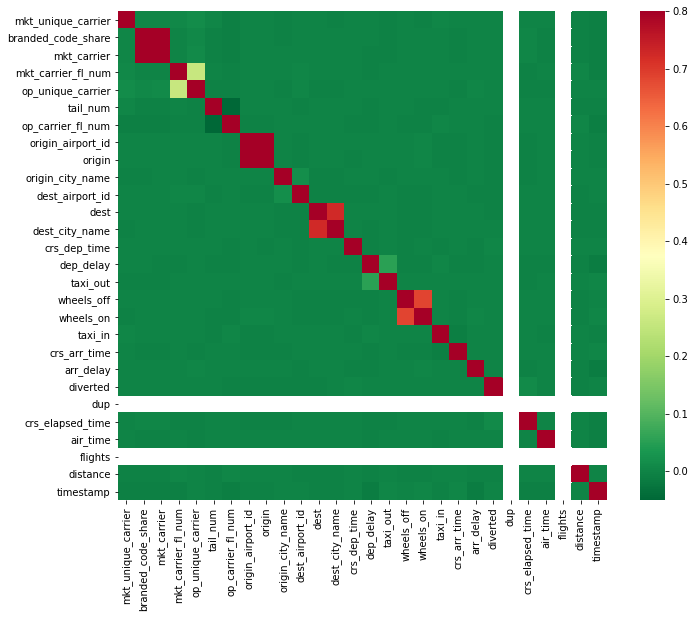

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns

corrmat = fl_df.corr()
f,ax = plt.subplots(figsize=(12,9))
sns.heatmap(corrmat, vmax=.8, square=True, cmap='RdYlGn_r')

## Remove feats, based on corr map

In [43]:
# remove 'branded_code_share','origin', 'dest_city_name', 'wheels_off'

In [44]:
import pandas as pd

# bring in data
path = '/Users/reneehall/Documents/Learning/lighthouse_labs/coursework-lighthouse-labs/Mid-term project/colab_data/'
fl_df = pd.read_csv(path+'cleaned_flights_sample.csv')

fl_df = remove_delay_outliers(fl_df)

# remove columns that we can't predict ahead of time, including departure delay
to_drop = ['cancellation_code', 'carrier_delay', 'weather_delay', 'nas_delay','security_delay','late_aircraft_delay','first_dep_time','total_add_gtime','longest_add_gtime','cancelled', 'dep_time', 'arr_time', 'actual_elapsed_time', 'dep_delay', 'branded_code_share','origin', 'dest_city_name', 'wheels_off']
fl_df = fl_df.drop(labels=to_drop, axis=1)


In [45]:
# need to transform categorical into continuous

# date string to unix
import datetime as dt 

fl_df['fl_date'] = pd.to_datetime(fl_df['fl_date'])
fl_df['timestamp'] = fl_df['fl_date'].map(dt.datetime.toordinal)
fl_df = fl_df.drop(labels=['fl_date'], axis=1)

# encode categorical vars
from sklearn import preprocessing

label_encoder = preprocessing.LabelEncoder()

cat_vars = fl_df.select_dtypes(include= 'object').columns.tolist()
for col in cat_vars:
    fl_df[col] = label_encoder.fit_transform(fl_df[col])

In [47]:
# separate x and y
X = fl_df.drop(labels=['arr_delay'], axis=1)
y = fl_df['arr_delay']

# make train-test split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, test_size=0.3, random_state=101)

In [48]:
import xgboost as xgb
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_percentage_error

xg = xgb.XGBRegressor()
xg.fit(X_train, y_train)
y_xg = xg.predict(X_test)

# evaluate using MAE
MAE = mean_absolute_error(y_test, y_xg)
print(f"MAE: {MAE}")

# evaluate using R2
R2 = r2_score(y_test, y_xg)
print(f"R2: {R2}")

# evaluate with adjusted R2
adj_R2 = 1 - ((1 - R2)*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1))
print(f"adj_R2: {adj_R2}")

# calculate MAPE
MAPE = mean_absolute_percentage_error(y_test,y_xg)
print(f"MAPE: {MAPE}")

MAE: 14.249177953398874
R2: 0.01069378332844484
adj_R2: 0.010559726867191532
MAPE: 262830169871092.1


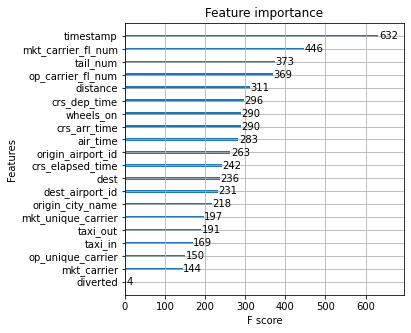

In [49]:
import matplotlib.pyplot as plt

xgb.plot_importance(xg)
plt.rcParams['figure.figsize'] = [5, 5]
plt.show()

<AxesSubplot:>

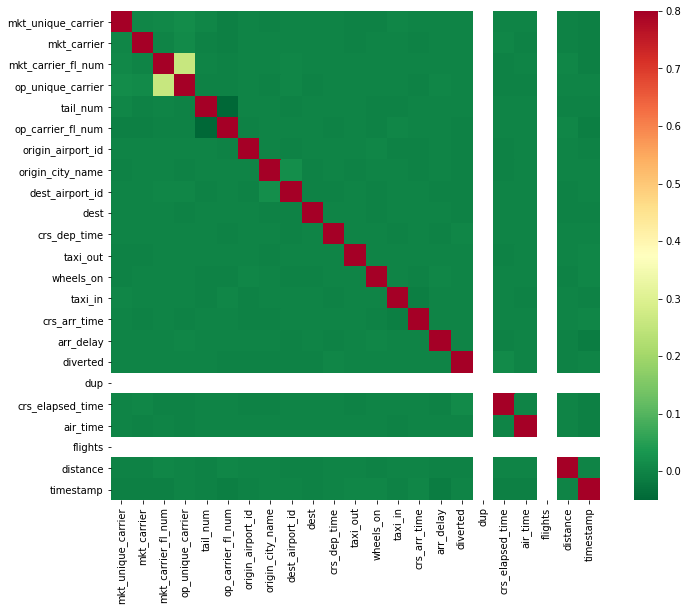

In [50]:
import matplotlib.pyplot as plt
import seaborn as sns

corrmat = fl_df.corr()
f,ax = plt.subplots(figsize=(12,9))
sns.heatmap(corrmat, vmax=.8, square=True, cmap='RdYlGn_r')

## remove diverted, add in time columns

In [51]:
import pandas as pd

# bring in data
path = '/Users/reneehall/Documents/Learning/lighthouse_labs/coursework-lighthouse-labs/Mid-term project/colab_data/'
fl_df = pd.read_csv(path+'cleaned_flights_sample.csv')

fl_df = remove_delay_outliers(fl_df)

# remove columns that we can't predict ahead of time, including departure delay
to_drop = ['cancellation_code', 'carrier_delay', 'weather_delay', 'nas_delay','security_delay','late_aircraft_delay','first_dep_time','total_add_gtime','longest_add_gtime','cancelled', 'dep_time', 'arr_time', 'actual_elapsed_time', 'dep_delay', 'branded_code_share','origin', 'dest_city_name', 'wheels_off', 'diverted']
fl_df = fl_df.drop(labels=to_drop, axis=1)



In [52]:
# need to transform categorical into continuous

# date string to unix
import datetime as dt 

fl_df['month'] = pd.to_datetime(fl_df['fl_date']).dt.month
fl_df['year'] = pd.to_datetime(fl_df['fl_date']).dt.year
fl_df['weekday'] = pd.to_datetime(fl_df['fl_date']).dt.weekday
fl_df['day_of_year'] = pd.to_datetime(fl_df['fl_date']).dt.strftime('%j')
fl_df = fl_df.drop(labels=['fl_date'], axis=1)
           
# create arr_hour and dep_hour columns and clean
fl_df['arr_hour'] = fl_df['crs_arr_time'].astype('str').str[:-4]
fl_df['arr_hour'] = fl_df.arr_hour.replace('', 0)
fl_df['arr_hour'] = fl_df.arr_hour.replace('1464.845427563', 14)
fl_df['arr_hour'] = fl_df.arr_hour.astype('int')

fl_df['dep_hour'] = fl_df['crs_dep_time'].astype('str').str[:-4]
fl_df['dep_hour'] = fl_df.dep_hour.replace('', 0)
fl_df['dep_hour'] = fl_df.dep_hour.replace('1335.3619765', 12)
fl_df['dep_hour'] = fl_df.dep_hour.astype('int')

# encode categorical vars
from sklearn import preprocessing

label_encoder = preprocessing.LabelEncoder()

cat_vars = fl_df.select_dtypes(include= 'object').columns.tolist()
for col in cat_vars:
    fl_df[col] = label_encoder.fit_transform(fl_df[col])

In [53]:
# separate x and y
X = fl_df.drop(labels=['arr_delay'], axis=1)
y = fl_df['arr_delay']

# make train-test split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, test_size=0.3, random_state=101)

In [54]:
import xgboost as xgb
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_percentage_error

xg = xgb.XGBRegressor()
xg.fit(X_train, y_train)
y_xg = xg.predict(X_test)

# evaluate using MAE
MAE = mean_absolute_error(y_test, y_xg)
print(f"MAE: {MAE}")

# evaluate using R2
R2 = r2_score(y_test, y_xg)
print(f"R2: {R2}")

# evaluate with adjusted R2
adj_R2 = 1 - ((1 - R2)*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1))
print(f"adj_R2: {adj_R2}")

# calculate MAPE
MAPE = mean_absolute_percentage_error(y_test,y_xg)
print(f"MAPE: {MAPE}")

MAE: 14.242610664429263
R2: 0.01056787054317665
adj_R2: 0.010409416111938907
MAPE: 261012918591562.56


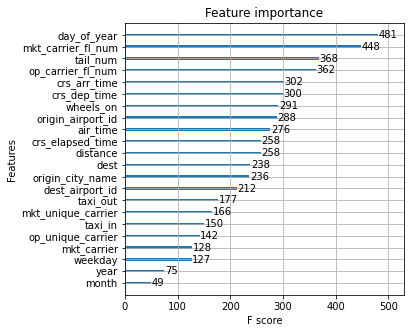

In [55]:
import matplotlib.pyplot as plt

xgb.plot_importance(xg)
plt.rcParams['figure.figsize'] = [5, 5]
plt.show()

<AxesSubplot:>

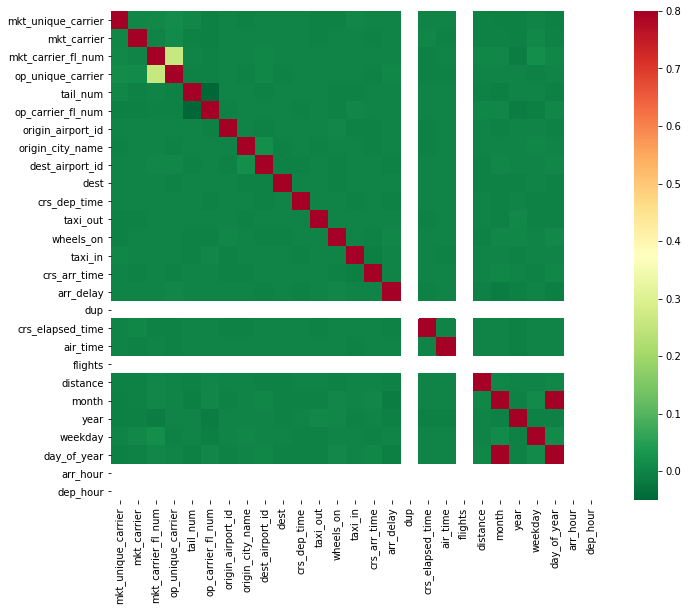

In [56]:
import matplotlib.pyplot as plt
import seaborn as sns

corrmat = fl_df.corr()
f,ax = plt.subplots(figsize=(12,9))
sns.heatmap(corrmat, vmax=.8, square=True, cmap='RdYlGn_r')

## feature engineering balanced dataset

In [1]:
import pandas as pd

# bring in data
path = '/Users/reneehall/Documents/Learning/lighthouse_labs/coursework-lighthouse-labs/Mid-term project/colab_data/'
fl_df = pd.read_csv(path+'cleaned_balanced_sample.csv')

#fl_df = remove_delay_outliers(fl_df)

# remove columns that we can't predict ahead of time, including departure delay
#to_drop = ['cancellation_code', 'carrier_delay', 'weather_delay', 'nas_delay','security_delay','late_aircraft_delay','first_dep_time','total_add_gtime','longest_add_gtime','cancelled', 'dep_time', 'arr_time', 'actual_elapsed_time', 'dep_delay', 'branded_code_share','origin', 'dest_city_name', 'wheels_off', 'diverted', 'wheels_on', 'taxi_out','taxi_in']
#fl_df = fl_df.drop(labels=to_drop, axis=1)

In [2]:
fl_df.isnull().sum()

fl_date                0
mkt_unique_carrier     0
branded_code_share     0
mkt_carrier            0
mkt_carrier_fl_num     0
op_unique_carrier      0
tail_num               0
op_carrier_fl_num      0
origin_airport_id      0
origin                 0
origin_city_name       0
dest_airport_id        0
dest                   0
dest_city_name         0
crs_dep_time           0
dep_time               0
dep_delay              0
taxi_out               0
wheels_off             0
wheels_on              0
taxi_in                0
crs_arr_time           0
arr_time               0
arr_delay              0
cancelled              0
diverted               0
crs_elapsed_time       0
actual_elapsed_time    0
air_time               0
flights                0
distance               0
dtype: int64

In [3]:
fl_df.shape

(600000, 31)

In [4]:
origin_daily_flights = fl_df.groupby(by=['fl_date', 'origin_airport_id']).flights.count().sort_values(ascending=False)

In [6]:
# join on date and origin_airport_id
fl_df = pd.merge(fl_df, origin_daily_flights, left_on=['fl_date','origin_airport_id'], right_on = ['fl_date','origin_airport_id'])

In [7]:
fl_df.rename(columns={'flights_y': 'origin_fl_density'}, inplace=True)
fl_df.columns

Index(['fl_date', 'mkt_unique_carrier', 'branded_code_share', 'mkt_carrier',
       'mkt_carrier_fl_num', 'op_unique_carrier', 'tail_num',
       'op_carrier_fl_num', 'origin_airport_id', 'origin', 'origin_city_name',
       'dest_airport_id', 'dest', 'dest_city_name', 'crs_dep_time', 'dep_time',
       'dep_delay', 'taxi_out', 'wheels_off', 'wheels_on', 'taxi_in',
       'crs_arr_time', 'arr_time', 'arr_delay', 'cancelled', 'diverted',
       'crs_elapsed_time', 'actual_elapsed_time', 'air_time', 'flights_x',
       'distance', 'origin_fl_density'],
      dtype='object')

In [8]:
fl_df.isnull().sum()

fl_date                0
mkt_unique_carrier     0
branded_code_share     0
mkt_carrier            0
mkt_carrier_fl_num     0
op_unique_carrier      0
tail_num               0
op_carrier_fl_num      0
origin_airport_id      0
origin                 0
origin_city_name       0
dest_airport_id        0
dest                   0
dest_city_name         0
crs_dep_time           0
dep_time               0
dep_delay              0
taxi_out               0
wheels_off             0
wheels_on              0
taxi_in                0
crs_arr_time           0
arr_time               0
arr_delay              0
cancelled              0
diverted               0
crs_elapsed_time       0
actual_elapsed_time    0
air_time               0
flights_x              0
distance               0
origin_fl_density      0
dtype: int64

In [9]:
fl_df.shape

(600000, 32)

In [10]:
dest_daily_flights = fl_df.groupby(by=['fl_date', 'dest_airport_id']).flights_x.count().sort_values(ascending=False)

In [11]:
# join on date and origin_airport_id
fl_df = pd.merge(fl_df, dest_daily_flights, left_on=['fl_date','dest_airport_id'], right_on = ['fl_date','dest_airport_id'])

In [12]:
fl_df.rename(columns={'flights_x_x': 'flights', 'flights_x_y': 'dest_fl_density'}, inplace=True)
fl_df.columns

Index(['fl_date', 'mkt_unique_carrier', 'branded_code_share', 'mkt_carrier',
       'mkt_carrier_fl_num', 'op_unique_carrier', 'tail_num',
       'op_carrier_fl_num', 'origin_airport_id', 'origin', 'origin_city_name',
       'dest_airport_id', 'dest', 'dest_city_name', 'crs_dep_time', 'dep_time',
       'dep_delay', 'taxi_out', 'wheels_off', 'wheels_on', 'taxi_in',
       'crs_arr_time', 'arr_time', 'arr_delay', 'cancelled', 'diverted',
       'crs_elapsed_time', 'actual_elapsed_time', 'air_time', 'flights',
       'distance', 'origin_fl_density', 'dest_fl_density'],
      dtype='object')

In [13]:
fl_df.isnull().sum()

fl_date                0
mkt_unique_carrier     0
branded_code_share     0
mkt_carrier            0
mkt_carrier_fl_num     0
op_unique_carrier      0
tail_num               0
op_carrier_fl_num      0
origin_airport_id      0
origin                 0
origin_city_name       0
dest_airport_id        0
dest                   0
dest_city_name         0
crs_dep_time           0
dep_time               0
dep_delay              0
taxi_out               0
wheels_off             0
wheels_on              0
taxi_in                0
crs_arr_time           0
arr_time               0
arr_delay              0
cancelled              0
diverted               0
crs_elapsed_time       0
actual_elapsed_time    0
air_time               0
flights                0
distance               0
origin_fl_density      0
dest_fl_density        0
dtype: int64

In [14]:
fl_df.shape

(600000, 33)

In [15]:
fl_df.to_csv(path+'balanced_more_flight_feats.csv', index=False)

In [16]:
import datetime as dt 

fl_df['day'] = pd.to_datetime(fl_df['fl_date']).dt.day
fl_df['month'] = pd.to_datetime(fl_df['fl_date']).dt.month
fl_df['year'] = pd.to_datetime(fl_df['fl_date']).dt.year
fl_df['weekday'] = pd.to_datetime(fl_df['fl_date']).dt.weekday
fl_df['day_of_year'] = pd.to_datetime(fl_df['fl_date']).dt.strftime('%j')

In [17]:
fl_df.shape

(600000, 38)

In [18]:
fl_df['timestamp'].head()

KeyError: 'timestamp'

In [19]:
# create arr_hour and dep_hour columns and clean
fl_df['crs_arr_hour'] = fl_df['crs_arr_time'].astype('str').str[:-2]
fl_df['crs_arr_hour'] = fl_df.crs_arr_hour.replace('', 0)
fl_df['crs_arr_hour'] = fl_df.crs_arr_hour.astype('int')

fl_df['crs_dep_hour'] = fl_df['crs_dep_time'].astype('str').str[:-2]
fl_df['crs_dep_hour'] = fl_df.crs_dep_hour.replace('', 0)
fl_df['crs_dep_hour'] = fl_df.crs_dep_hour.astype('int')

In [20]:
fl_df['timestamp'] = pd.to_datetime(fl_df['fl_date']).map(dt.datetime.toordinal)

In [21]:
fl_df.crs_dep_hour.unique()

array([12,  7, 13, 10, 17, 20,  8, 16, 19, 15, 11,  1, 21, 22, 18,  9,  6,
       14,  5, 23,  0,  2,  3,  4])

In [22]:
fl_df.shape

(600000, 41)

In [23]:
fl_df.to_csv(path+'balanced_more_flight_feats.csv',index=False)

In [24]:
fl_df['crs_arr_daytime'] = (fl_df['crs_arr_hour'] > 6) & (fl_df['crs_arr_hour'] < 18)

In [25]:
fl_df['crs_dep_daytime'] = (fl_df['crs_dep_hour'] > 6) & (fl_df['crs_dep_hour'] < 18)

In [26]:
fl_df.isnull().sum()

fl_date                0
mkt_unique_carrier     0
branded_code_share     0
mkt_carrier            0
mkt_carrier_fl_num     0
op_unique_carrier      0
tail_num               0
op_carrier_fl_num      0
origin_airport_id      0
origin                 0
origin_city_name       0
dest_airport_id        0
dest                   0
dest_city_name         0
crs_dep_time           0
dep_time               0
dep_delay              0
taxi_out               0
wheels_off             0
wheels_on              0
taxi_in                0
crs_arr_time           0
arr_time               0
arr_delay              0
cancelled              0
diverted               0
crs_elapsed_time       0
actual_elapsed_time    0
air_time               0
flights                0
distance               0
origin_fl_density      0
dest_fl_density        0
day                    0
month                  0
year                   0
weekday                0
day_of_year            0
crs_arr_hour           0
crs_dep_hour           0


In [27]:
fl_df['crs_dep_daytime'] = fl_df['crs_dep_daytime'].astype(int).astype('category')

In [28]:
fl_df['crs_arr_daytime'] = fl_df['crs_arr_daytime'].astype(int).astype('category')

In [29]:
fl_df.isnull().sum()

fl_date                0
mkt_unique_carrier     0
branded_code_share     0
mkt_carrier            0
mkt_carrier_fl_num     0
op_unique_carrier      0
tail_num               0
op_carrier_fl_num      0
origin_airport_id      0
origin                 0
origin_city_name       0
dest_airport_id        0
dest                   0
dest_city_name         0
crs_dep_time           0
dep_time               0
dep_delay              0
taxi_out               0
wheels_off             0
wheels_on              0
taxi_in                0
crs_arr_time           0
arr_time               0
arr_delay              0
cancelled              0
diverted               0
crs_elapsed_time       0
actual_elapsed_time    0
air_time               0
flights                0
distance               0
origin_fl_density      0
dest_fl_density        0
day                    0
month                  0
year                   0
weekday                0
day_of_year            0
crs_arr_hour           0
crs_dep_hour           0


In [30]:
fl_df.shape

(600000, 43)

In [32]:
fl_df = pd.read_csv(path+'balanced_more_flight_feats.csv')

In [33]:
fl_df.shape

(600000, 53)

In [34]:
fl_df['predicted_speed'] = fl_df['distance']/fl_df['crs_elapsed_time']

In [35]:
fl_df.to_csv(path+'balanced_more_flight_feats.csv',index=False)

In [372]:
fl_df.isnull().sum()

fl_date                   0
mkt_unique_carrier        0
branded_code_share        0
mkt_carrier               0
mkt_carrier_fl_num        0
op_unique_carrier         0
tail_num                  0
op_carrier_fl_num         0
origin_airport_id         0
origin                    0
origin_city_name          0
dest_airport_id           0
dest                      0
dest_city_name            0
crs_dep_time              0
dep_time                  0
dep_delay                 0
taxi_out                  0
wheels_off                0
wheels_on                 0
taxi_in                   0
crs_arr_time              0
arr_time                  0
arr_delay                 0
cancelled                 0
diverted                  0
crs_elapsed_time          0
actual_elapsed_time       0
air_time                  0
flights                   0
distance                  0
origin_fl_density         0
dest_fl_density           0
day                       0
month                     0
year                

In [175]:
pass_df = pd.read_csv(path+'cleaned_passengers.csv')
pass_df.head(10)

,departures_scheduled,departures_performed,payload,seats,passengers,freight,mail,distance,ramp_to_ramp,air_time,...,dest_country,dest_country_name,aircraft_group,aircraft_type,aircraft_config,year,month,distance_group,class,data_source
0,6.0,6.0,223200.0,1116.0,906.0,0.0,0.0,1259.0,1044.0,918.0,...,US,United States,6,694,1,2019,12,3,F,DU
1,6.0,6.0,187200.0,936.0,861.0,0.0,0.0,1208.0,1062.0,960.0,...,US,United States,6,698,1,2019,12,3,F,DU
2,6.0,6.0,214200.0,1071.0,982.0,0.0,0.0,917.0,768.0,690.0,...,US,United States,6,694,1,2019,12,2,F,DU
3,6.0,6.0,216000.0,1080.0,775.0,0.0,0.0,598.0,582.0,492.0,...,US,United States,6,694,1,2019,12,2,F,DU
4,6.0,6.0,173222.0,0.0,0.0,173220.0,0.0,620.0,542.0,476.0,...,US,United States,6,691,2,2019,2,2,G,DU
5,6.0,6.0,1359188.0,0.0,0.0,596326.0,24038.0,2603.0,2174.0,2056.0,...,US,United States,8,819,2,2019,2,6,G,DU
6,6.0,6.0,383246.0,0.0,0.0,176209.0,1920.0,1796.0,1276.0,1168.0,...,US,United States,6,622,2,2019,2,4,G,DU
7,6.0,6.0,1055335.0,0.0,0.0,434154.0,0.0,1950.0,1406.0,1271.0,...,US,United States,7,740,2,2019,2,4,G,DU
8,6.0,6.0,1357998.0,0.0,0.0,922930.0,10275.0,4383.0,3425.0,3273.0,...,US,United States,8,821,2,2019,2,9,G,DU
9,6.0,6.0,367540.0,0.0,0.0,367537.0,0.0,491.0,571.0,465.0,...,US,United States,6,626,2,2019,2,1,G,DU


In [373]:
pass_per_mo_origin_airport = pass_df.groupby(by=['origin_airport_id','year','month']).passengers.sum().sort_values(ascending=False)

In [374]:
fl_df = pd.merge(fl_df, pass_per_mo_origin_airport, left_on=['origin_airport_id','year','month'], right_on = ['origin_airport_id','year','month'])

In [375]:
fl_df.rename(columns={'passengers': 'origin_passengers/mo'}, inplace=True)
fl_df.columns

Index(['fl_date', 'mkt_unique_carrier', 'branded_code_share', 'mkt_carrier',
       'mkt_carrier_fl_num', 'op_unique_carrier', 'tail_num',
       'op_carrier_fl_num', 'origin_airport_id', 'origin', 'origin_city_name',
       'dest_airport_id', 'dest', 'dest_city_name', 'crs_dep_time', 'dep_time',
       'dep_delay', 'taxi_out', 'wheels_off', 'wheels_on', 'taxi_in',
       'crs_arr_time', 'arr_time', 'arr_delay', 'cancelled', 'diverted',
       'crs_elapsed_time', 'actual_elapsed_time', 'air_time', 'flights',
       'distance', 'origin_fl_density', 'dest_fl_density', 'day', 'month',
       'year', 'weekday', 'day_of_year', 'crs_arr_hour', 'crs_dep_hour',
       'timestamp', 'crs_arr_daytime', 'crs_dep_daytime',
       'predicted_speed_mi/min', 'actual_speed_mi/min',
       'origin_passengers/mo'],
      dtype='object')

In [376]:
fl_df.isnull().sum()

fl_date                   0
mkt_unique_carrier        0
branded_code_share        0
mkt_carrier               0
mkt_carrier_fl_num        0
op_unique_carrier         0
tail_num                  0
op_carrier_fl_num         0
origin_airport_id         0
origin                    0
origin_city_name          0
dest_airport_id           0
dest                      0
dest_city_name            0
crs_dep_time              0
dep_time                  0
dep_delay                 0
taxi_out                  0
wheels_off                0
wheels_on                 0
taxi_in                   0
crs_arr_time              0
arr_time                  0
arr_delay                 0
cancelled                 0
diverted                  0
crs_elapsed_time          0
actual_elapsed_time       0
air_time                  0
flights                   0
distance                  0
origin_fl_density         0
dest_fl_density           0
day                       0
month                     0
year                

In [377]:
pass_per_mo_dest_airport = pass_df.groupby(by=['dest_airport_id','year','month']).passengers.sum().sort_values(ascending=False)

In [196]:
pass_per_mo_dest_airport

dest_airport_id  year  month
10397            2019  7        5027887.0
                 2018  7        4851702.0
                 2019  6        4844537.0
                       8        4840265.0
                       5        4774602.0
                                  ...    
10643            2016  4              0.0
13546            2015  6              0.0
                       9              0.0
                       11             0.0
16876            2019  12             0.0
Name: passengers, Length: 72234, dtype: float64

In [378]:
fl_df = pd.merge(fl_df, pass_per_mo_dest_airport, left_on=['dest_airport_id','year','month'], right_on = ['dest_airport_id','year','month'])

In [198]:
fl_df[['origin_airport_id','year','month','passengers']].loc[(fl_df['origin_airport_id'] == 10397)&(fl_df['year'] == 2019)&(fl_df['month'] == 7)]

,origin_airport_id,year,month,passengers
167503,10397,2019,7,1889088.0
167504,10397,2019,7,1889088.0
167505,10397,2019,7,1889088.0
167506,10397,2019,7,1889088.0
167507,10397,2019,7,1889088.0
...,...,...,...,...
474394,10397,2019,7,24682.0
474405,10397,2019,7,25106.0
474418,10397,2019,7,5754.0
474421,10397,2019,7,1006.0


In [199]:
fl_df.columns

Index(['fl_date', 'mkt_unique_carrier', 'branded_code_share', 'mkt_carrier',
       'mkt_carrier_fl_num', 'op_unique_carrier', 'tail_num',
       'op_carrier_fl_num', 'origin_airport_id', 'origin', 'origin_city_name',
       'dest_airport_id', 'dest', 'dest_city_name', 'crs_dep_time', 'dep_time',
       'dep_delay', 'taxi_out', 'wheels_off', 'wheels_on', 'taxi_in',
       'crs_arr_time', 'arr_time', 'arr_delay', 'cancelled',
       'cancellation_code', 'diverted', 'dup', 'crs_elapsed_time',
       'actual_elapsed_time', 'air_time', 'flights', 'distance',
       'carrier_delay', 'weather_delay', 'nas_delay', 'security_delay',
       'late_aircraft_delay', 'first_dep_time', 'total_add_gtime',
       'longest_add_gtime', 'origin_fl_density', 'dest_fl_density', 'day',
       'month', 'year', 'weekday', 'day_of_year', 'arr_hour', 'dep_hour',
       'timestamp', 'arr_daytime', 'dep_daytime', 'predicted_speed_mi/min',
       'actual_speed_mi/min', 'origin_passengers/mo', 'passengers'],
      

In [379]:
fl_df.rename(columns={'passengers': 'dest_passengers/mo'}, inplace=True)
fl_df.columns

Index(['fl_date', 'mkt_unique_carrier', 'branded_code_share', 'mkt_carrier',
       'mkt_carrier_fl_num', 'op_unique_carrier', 'tail_num',
       'op_carrier_fl_num', 'origin_airport_id', 'origin', 'origin_city_name',
       'dest_airport_id', 'dest', 'dest_city_name', 'crs_dep_time', 'dep_time',
       'dep_delay', 'taxi_out', 'wheels_off', 'wheels_on', 'taxi_in',
       'crs_arr_time', 'arr_time', 'arr_delay', 'cancelled', 'diverted',
       'crs_elapsed_time', 'actual_elapsed_time', 'air_time', 'flights',
       'distance', 'origin_fl_density', 'dest_fl_density', 'day', 'month',
       'year', 'weekday', 'day_of_year', 'crs_arr_hour', 'crs_dep_hour',
       'timestamp', 'crs_arr_daytime', 'crs_dep_daytime',
       'predicted_speed_mi/min', 'actual_speed_mi/min', 'origin_passengers/mo',
       'dest_passengers/mo'],
      dtype='object')

In [380]:
fl_df.isnull().sum()

fl_date                   0
mkt_unique_carrier        0
branded_code_share        0
mkt_carrier               0
mkt_carrier_fl_num        0
op_unique_carrier         0
tail_num                  0
op_carrier_fl_num         0
origin_airport_id         0
origin                    0
origin_city_name          0
dest_airport_id           0
dest                      0
dest_city_name            0
crs_dep_time              0
dep_time                  0
dep_delay                 0
taxi_out                  0
wheels_off                0
wheels_on                 0
taxi_in                   0
crs_arr_time              0
arr_time                  0
arr_delay                 0
cancelled                 0
diverted                  0
crs_elapsed_time          0
actual_elapsed_time       0
air_time                  0
flights                   0
distance                  0
origin_fl_density         0
dest_fl_density           0
day                       0
month                     0
year                

In [256]:
fl_df.to_csv(path+'balanced_more_flight_feats.csv',index=False)

In [381]:
origin_mo_freight = pass_df.groupby(by=['origin_airport_id','year','month']).freight.sum().sort_values(ascending=False)

In [382]:
fl_df = pd.merge(fl_df, origin_mo_freight, left_on=['origin_airport_id','year','month'], right_on = ['origin_airport_id','year','month'])

In [261]:
fl_df.columns

Index(['fl_date', 'mkt_unique_carrier', 'branded_code_share', 'mkt_carrier',
       'mkt_carrier_fl_num', 'op_unique_carrier', 'tail_num',
       'op_carrier_fl_num', 'origin_airport_id', 'origin', 'origin_city_name',
       'dest_airport_id', 'dest', 'dest_city_name', 'crs_dep_time', 'dep_time',
       'dep_delay', 'taxi_out', 'wheels_off', 'wheels_on', 'taxi_in',
       'crs_arr_time', 'arr_time', 'arr_delay', 'cancelled', 'diverted',
       'crs_elapsed_time', 'actual_elapsed_time', 'air_time', 'flights',
       'distance', 'origin_fl_density', 'dest_fl_density', 'day', 'month',
       'year', 'weekday', 'day_of_year', 'crs_dep_hour', 'crs_arr_hour',
       'timestamp', 'arr_daytime', 'dep_daytime', 'predicted_speed_mi/min',
       'actual_speed_mi/min', 'origin_passengers/mo', 'dest_passengers/mo',
       'freight'],
      dtype='object')

In [383]:
fl_df.rename(columns={'freight': 'origin_freight/mo'}, inplace=True)

In [384]:
fl_df.isnull().sum()

fl_date                   0
mkt_unique_carrier        0
branded_code_share        0
mkt_carrier               0
mkt_carrier_fl_num        0
op_unique_carrier         0
tail_num                  0
op_carrier_fl_num         0
origin_airport_id         0
origin                    0
origin_city_name          0
dest_airport_id           0
dest                      0
dest_city_name            0
crs_dep_time              0
dep_time                  0
dep_delay                 0
taxi_out                  0
wheels_off                0
wheels_on                 0
taxi_in                   0
crs_arr_time              0
arr_time                  0
arr_delay                 0
cancelled                 0
diverted                  0
crs_elapsed_time          0
actual_elapsed_time       0
air_time                  0
flights                   0
distance                  0
origin_fl_density         0
dest_fl_density           0
day                       0
month                     0
year                

In [385]:
dest_mo_freight = pass_df.groupby(by=['dest_airport_id','year','month']).freight.sum().sort_values(ascending=False)

In [386]:
fl_df = pd.merge(fl_df, dest_mo_freight, left_on=['dest_airport_id','year','month'], right_on = ['dest_airport_id','year','month'])

In [387]:
fl_df.columns

Index(['fl_date', 'mkt_unique_carrier', 'branded_code_share', 'mkt_carrier',
       'mkt_carrier_fl_num', 'op_unique_carrier', 'tail_num',
       'op_carrier_fl_num', 'origin_airport_id', 'origin', 'origin_city_name',
       'dest_airport_id', 'dest', 'dest_city_name', 'crs_dep_time', 'dep_time',
       'dep_delay', 'taxi_out', 'wheels_off', 'wheels_on', 'taxi_in',
       'crs_arr_time', 'arr_time', 'arr_delay', 'cancelled', 'diverted',
       'crs_elapsed_time', 'actual_elapsed_time', 'air_time', 'flights',
       'distance', 'origin_fl_density', 'dest_fl_density', 'day', 'month',
       'year', 'weekday', 'day_of_year', 'crs_arr_hour', 'crs_dep_hour',
       'timestamp', 'crs_arr_daytime', 'crs_dep_daytime',
       'predicted_speed_mi/min', 'actual_speed_mi/min', 'origin_passengers/mo',
       'dest_passengers/mo', 'origin_freight/mo', 'freight'],
      dtype='object')

In [388]:
fl_df.isnull().sum()

fl_date                   0
mkt_unique_carrier        0
branded_code_share        0
mkt_carrier               0
mkt_carrier_fl_num        0
op_unique_carrier         0
tail_num                  0
op_carrier_fl_num         0
origin_airport_id         0
origin                    0
origin_city_name          0
dest_airport_id           0
dest                      0
dest_city_name            0
crs_dep_time              0
dep_time                  0
dep_delay                 0
taxi_out                  0
wheels_off                0
wheels_on                 0
taxi_in                   0
crs_arr_time              0
arr_time                  0
arr_delay                 0
cancelled                 0
diverted                  0
crs_elapsed_time          0
actual_elapsed_time       0
air_time                  0
flights                   0
distance                  0
origin_fl_density         0
dest_fl_density           0
day                       0
month                     0
year                

In [389]:
fl_df.rename(columns={'freight': 'dest_freight/mo'}, inplace=True)

In [269]:
fl_df.to_csv(path+'balanced_more_flight_feats.csv',index=False)

In [390]:
intl_departures = pass_df.loc[(pass_df['dest_country'] != 'US')&(pass_df['origin_country'] == 'US')].groupby(by=['origin_airport_id','year','month']).departures_performed.sum().sort_values(ascending=False)

In [391]:
intl_arrivals = pass_df.loc[(pass_df['origin_country'] != 'US')&(pass_df['dest_country'] == 'US')].groupby(by=['dest_airport_id','year','month']).departures_performed.sum().sort_values(ascending=False)

In [392]:
fl_df = pd.merge(fl_df, intl_departures, left_on=['origin_airport_id','year','month'], right_on = ['origin_airport_id','year','month'])

In [282]:
fl_df.columns

Index(['fl_date', 'mkt_unique_carrier', 'branded_code_share', 'mkt_carrier',
       'mkt_carrier_fl_num', 'op_unique_carrier', 'tail_num',
       'op_carrier_fl_num', 'origin_airport_id', 'origin', 'origin_city_name',
       'dest_airport_id', 'dest', 'dest_city_name', 'crs_dep_time', 'dep_time',
       'dep_delay', 'taxi_out', 'wheels_off', 'wheels_on', 'taxi_in',
       'crs_arr_time', 'arr_time', 'arr_delay', 'cancelled', 'diverted',
       'crs_elapsed_time', 'actual_elapsed_time', 'air_time', 'flights',
       'distance', 'origin_fl_density', 'dest_fl_density', 'day', 'month',
       'year', 'weekday', 'day_of_year', 'crs_dep_hour', 'crs_arr_hour',
       'timestamp', 'arr_daytime', 'dep_daytime', 'predicted_speed_mi/min',
       'actual_speed_mi/min', 'origin_passengers/mo', 'dest_passengers/mo',
       'origin_freight/mo', 'dest_freight/mo', 'departures_performed'],
      dtype='object')

In [393]:
fl_df.rename(columns={'departures_performed': 'origin_intl_dep/mo'}, inplace=True)

In [394]:
fl_df = pd.merge(fl_df, intl_departures, left_on=['dest_airport_id','year','month'], right_on = ['origin_airport_id','year','month'])

In [287]:
fl_df.columns

Index(['fl_date', 'mkt_unique_carrier', 'branded_code_share', 'mkt_carrier',
       'mkt_carrier_fl_num', 'op_unique_carrier', 'tail_num',
       'op_carrier_fl_num', 'origin_airport_id', 'origin', 'origin_city_name',
       'dest_airport_id', 'dest', 'dest_city_name', 'crs_dep_time', 'dep_time',
       'dep_delay', 'taxi_out', 'wheels_off', 'wheels_on', 'taxi_in',
       'crs_arr_time', 'arr_time', 'arr_delay', 'cancelled', 'diverted',
       'crs_elapsed_time', 'actual_elapsed_time', 'air_time', 'flights',
       'distance', 'origin_fl_density', 'dest_fl_density', 'day', 'month',
       'year', 'weekday', 'day_of_year', 'crs_dep_hour', 'crs_arr_hour',
       'timestamp', 'arr_daytime', 'dep_daytime', 'predicted_speed_mi/min',
       'actual_speed_mi/min', 'origin_passengers/mo', 'dest_passengers/mo',
       'origin_freight/mo', 'dest_freight/mo', 'intl_dep/mo',
       'departures_performed'],
      dtype='object')

In [395]:
fl_df.rename(columns={'departures_performed': 'dest_intl_dep/mo'}, inplace=True)

In [396]:
fl_df = pd.merge(fl_df, intl_arrivals, left_on=['origin_airport_id','year','month'], right_on = ['dest_airport_id','year','month'])

In [290]:
fl_df.columns

Index(['fl_date', 'mkt_unique_carrier', 'branded_code_share', 'mkt_carrier',
       'mkt_carrier_fl_num', 'op_unique_carrier', 'tail_num',
       'op_carrier_fl_num', 'origin_airport_id', 'origin', 'origin_city_name',
       'dest_airport_id', 'dest', 'dest_city_name', 'crs_dep_time', 'dep_time',
       'dep_delay', 'taxi_out', 'wheels_off', 'wheels_on', 'taxi_in',
       'crs_arr_time', 'arr_time', 'arr_delay', 'cancelled', 'diverted',
       'crs_elapsed_time', 'actual_elapsed_time', 'air_time', 'flights',
       'distance', 'origin_fl_density', 'dest_fl_density', 'day', 'month',
       'year', 'weekday', 'day_of_year', 'crs_dep_hour', 'crs_arr_hour',
       'timestamp', 'arr_daytime', 'dep_daytime', 'predicted_speed_mi/min',
       'actual_speed_mi/min', 'origin_passengers/mo', 'dest_passengers/mo',
       'origin_freight/mo', 'dest_freight/mo', 'intl_dep/mo',
       'dest_intl_dep/mo', 'departures_performed'],
      dtype='object')

In [397]:
fl_df.rename(columns={'departures_performed': 'origin_intl_arr/mo'}, inplace=True)

In [398]:
fl_df = pd.merge(fl_df, intl_arrivals, left_on=['dest_airport_id','year','month'], right_on = ['dest_airport_id','year','month'])

In [399]:
fl_df.rename(columns={'departures_performed': 'dest_intl_arr/mo'}, inplace=True)

In [400]:
fl_df.isnull().sum()

fl_date                   0
mkt_unique_carrier        0
branded_code_share        0
mkt_carrier               0
mkt_carrier_fl_num        0
op_unique_carrier         0
tail_num                  0
op_carrier_fl_num         0
origin_airport_id         0
origin                    0
origin_city_name          0
dest_airport_id           0
dest                      0
dest_city_name            0
crs_dep_time              0
dep_time                  0
dep_delay                 0
taxi_out                  0
wheels_off                0
wheels_on                 0
taxi_in                   0
crs_arr_time              0
arr_time                  0
arr_delay                 0
cancelled                 0
diverted                  0
crs_elapsed_time          0
actual_elapsed_time       0
air_time                  0
flights                   0
distance                  0
origin_fl_density         0
dest_fl_density           0
day                       0
month                     0
year                

In [401]:
fl_df.to_csv(path+'balanced_more_flight_feats.csv',index=False)

In [296]:
fl_df.head()

,fl_date,mkt_unique_carrier,branded_code_share,mkt_carrier,mkt_carrier_fl_num,op_unique_carrier,tail_num,op_carrier_fl_num,origin_airport_id,origin,...,predicted_speed_mi/min,actual_speed_mi/min,origin_passengers/mo,dest_passengers/mo,origin_freight/mo,dest_freight/mo,intl_dep/mo,dest_intl_dep/mo,origin_intl_arr/mo,dest_intl_arr/mo
0,2018-04-05,3,15,10,136,24,5787,2617,14057,267,...,0.795181,3.093750,768005.0,1180156.0,17979318.0,16306607.0,286.0,409.0,285.0,414.0
1,2018-04-18,8,6,3,463,3,1910,2215,14057,267,...,4.206107,4.833333,768005.0,1180156.0,17979318.0,16306607.0,286.0,409.0,285.0,414.0
2,2018-04-06,0,1,0,5686,7,4723,5203,14057,267,...,14.213115,4.982759,768005.0,1180156.0,17979318.0,16306607.0,286.0,409.0,285.0,414.0
3,2018-04-01,1,5,3,5795,7,1690,1586,14057,267,...,5.379630,4.801653,768005.0,1180156.0,17979318.0,16306607.0,286.0,409.0,285.0,414.0
4,2018-04-05,3,15,10,5996,19,6047,2397,10397,22,...,4.076923,5.605769,4371731.0,1180156.0,66052566.0,16306607.0,3445.0,409.0,3429.0,414.0


In [297]:
fl_df.columns

Index(['fl_date', 'mkt_unique_carrier', 'branded_code_share', 'mkt_carrier',
       'mkt_carrier_fl_num', 'op_unique_carrier', 'tail_num',
       'op_carrier_fl_num', 'origin_airport_id', 'origin', 'origin_city_name',
       'dest_airport_id', 'dest', 'dest_city_name', 'crs_dep_time', 'dep_time',
       'dep_delay', 'taxi_out', 'wheels_off', 'wheels_on', 'taxi_in',
       'crs_arr_time', 'arr_time', 'arr_delay', 'cancelled', 'diverted',
       'crs_elapsed_time', 'actual_elapsed_time', 'air_time', 'flights',
       'distance', 'origin_fl_density', 'dest_fl_density', 'day', 'month',
       'year', 'weekday', 'day_of_year', 'crs_dep_hour', 'crs_arr_hour',
       'timestamp', 'arr_daytime', 'dep_daytime', 'predicted_speed_mi/min',
       'actual_speed_mi/min', 'origin_passengers/mo', 'dest_passengers/mo',
       'origin_freight/mo', 'dest_freight/mo', 'intl_dep/mo',
       'dest_intl_dep/mo', 'origin_intl_arr/mo', 'dest_intl_arr/mo'],
      dtype='object')

In [272]:
pass_df.columns

Index(['departures_scheduled', 'departures_performed', 'payload', 'seats',
       'passengers', 'freight', 'mail', 'distance', 'ramp_to_ramp', 'air_time',
       'unique_carrier', 'airline_id', 'unique_carrier_name', 'region',
       'carrier', 'carrier_name', 'carrier_group', 'carrier_group_new',
       'origin_airport_id', 'origin_city_market_id', 'origin',
       'origin_city_name', 'origin_country', 'origin_country_name',
       'dest_airport_id', 'dest_city_market_id', 'dest', 'dest_city_name',
       'dest_country', 'dest_country_name', 'aircraft_group', 'aircraft_type',
       'aircraft_config', 'year', 'month', 'distance_group', 'class',
       'data_source'],
      dtype='object')

In [275]:
pass_df.dest_country.unique()

array(['US', 'CA', 'MX', 'DO', 'BS', 'AR', 'CU', 'EC', 'HK', 'CN', 'IE',
       'ES', 'JM', 'SV', 'HN', 'PA', 'GT', 'FR', 'CH', 'JP', 'PW', 'FM',
       'TT', 'PF', 'SX', 'CR', 'TC', 'HT', 'KY', 'GD', 'LC', 'KR', 'GB',
       'NI', 'PE', 'CO', 'GY', 'AW', 'AG', 'DE', 'BZ', 'MQ', 'BQ', 'BM',
       'TW', 'ZA', 'KN', 'BR', 'BB', 'SN', 'CL', 'NL', 'AI', 'PT', 'IT',
       'CW', 'IN', 'BE', 'DK', 'IS', 'GR', 'AU', 'NZ', 'HR', 'PH', 'DM',
       'NG', 'IL', 'BO', 'GH', 'MH', 'AE', 'BL', 'GP', 'VG', 'UY', 'VE',
       'CZ', 'HU', 'SE', 'SG', 'TR', 'WS', 'TO', 'AZ', 'MA', 'SA', 'DZ',
       'ET', 'LV', 'LU', 'JO', 'BH', 'EG', 'RS', 'PL', 'NO', 'FI', 'AT',
       'KW', 'UA', 'PY', 'SR', 'QA', 'RU', 'MY', 'VC', 'CK', 'KH', 'RO',
       'BJ', 'GM', 'UZ', 'KI', 'FJ', 'CY', 'MR', 'KE', 'MO', 'MT', 'BD',
       'GL', 'KZ', 'PG', 'GF', 'AF', 'CV', 'TH', 'EE', 'BG', 'MF', 'AO',
       'MD', 'MM', 'TJ', 'LT', 'MU', 'NE', 'NP', 'LB', 'ME', 'PK', 'TN',
       'NC', 'UG', 'LR', 'GA', 'GE', 'VN', 'DJ', 'M

In [ ]:
# need to transform categorical into continuous

# date string to unix
import datetime as dt 

fl_df['day'] = pd_to_datetime(fl_df['fl_date']).dt.day
fl_df['month'] = pd.to_datetime(fl_df['fl_date']).dt.month
fl_df['year'] = pd.to_datetime(fl_df['fl_date']).dt.year
fl_df['weekday'] = pd.to_datetime(fl_df['fl_date']).dt.weekday
fl_df['day_of_year'] = pd.to_datetime(fl_df['fl_date']).dt.strftime('%j')
fl_df = fl_df.drop(labels=['fl_date'], axis=1)
           
# create arr_hour and dep_hour columns and clean
fl_df['arr_hour'] = fl_df['crs_arr_time'].astype('str').str[:-4]
fl_df['arr_hour'] = fl_df.arr_hour.replace('', 0)
fl_df['arr_hour'] = fl_df.arr_hour.replace('1464.845427563', 14)
fl_df['arr_hour'] = fl_df.arr_hour.astype('int')

fl_df['dep_hour'] = fl_df['crs_dep_time'].astype('str').str[:-4]
fl_df['dep_hour'] = fl_df.dep_hour.replace('', 0)
fl_df['dep_hour'] = fl_df.dep_hour.replace('1335.3619765', 12)
fl_df['dep_hour'] = fl_df.dep_hour.astype('int')

# encode categorical vars
from sklearn import preprocessing

label_encoder = preprocessing.LabelEncoder()

cat_vars = fl_df.select_dtypes(include= 'object').columns.tolist()
for col in cat_vars:
    fl_df[col] = label_encoder.fit_transform(fl_df[col])

## Strict outliers, scaled

In [29]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

Xsc = scaler.fit_transform(X)

In [31]:
# make train-test split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(Xsc, y, train_size=0.7, test_size=0.3, random_state=101)

In [32]:
import xgboost as xgb
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_percentage_error

xg = xgb.XGBRegressor()
xg.fit(X_train, y_train)
y_xg = xg.predict(X_test)

# evaluate using MAE
MAE = mean_absolute_error(y_test, y_xg)
print(f"MAE: {MAE}")

# evaluate using R2
R2 = r2_score(y_test, y_xg)
print(f"R2: {R2}")

# evaluate with adjusted R2
adj_R2 = 1 - ((1 - R2)*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1))
print(f"adj_R2: {adj_R2}")

# calculate MAPE
MAPE = mean_absolute_percentage_error(y_test,y_xg)
print(f"MAPE: {MAPE}")

MAE: 14.246217775565905
R2: 0.010168667322529967
adj_R2: 0.01001014896015695
MAPE: 258445662535949.2


## Hour model with strict outliers

In [33]:
# bring in data
path = '/Users/reneehall/Documents/Learning/lighthouse_labs/coursework-lighthouse-labs/Mid-term project/colab_data/'
fl_df = pd.read_csv(path+'cleaned_flights_sample.csv')

# remove outliers
fl_df = remove_delay_outliers(fl_df)

# remove columns that we can't predict ahead of time, including departure delay
to_drop = ['cancellation_code', 'carrier_delay', 'weather_delay', 'nas_delay','security_delay','late_aircraft_delay','first_dep_time','total_add_gtime','longest_add_gtime', 'dep_delay', 'cancelled', 'dep_time', 'arr_time']
fl_df = fl_df.drop(labels=to_drop, axis=1)

# encode cat vars
import datetime as dt 

fl_df['month'] = pd.to_datetime(fl_df['fl_date']).dt.month
fl_df['year'] = pd.to_datetime(fl_df['fl_date']).dt.year
fl_df['weekday'] = pd.to_datetime(fl_df['fl_date']).dt.weekday
fl_df['day_of_year'] = pd.to_datetime(fl_df['fl_date']).dt.strftime('%j')
fl_df = fl_df.drop(labels=['fl_date'], axis=1)
           
# create arr_hour and dep_hour columns and clean
fl_df['arr_hour'] = fl_df['crs_arr_time'].astype('str').str[:-4]
fl_df['arr_hour'] = fl_df.arr_hour.replace('', 0)
fl_df['arr_hour'] = fl_df.arr_hour.replace('1464.845427563', 14)
fl_df['arr_hour'] = fl_df.arr_hour.astype('int')

fl_df['dep_hour'] = fl_df['crs_dep_time'].astype('str').str[:-4]
fl_df['dep_hour'] = fl_df.dep_hour.replace('', 0)
fl_df['dep_hour'] = fl_df.dep_hour.replace('1335.3619765', 12)
fl_df['dep_hour'] = fl_df.dep_hour.astype('int')


# encode categorical vars
from sklearn import preprocessing

label_encoder = preprocessing.LabelEncoder()

cat_vars = fl_df.select_dtypes(include= 'object').columns.tolist()
for col in cat_vars:
    fl_df[col] = label_encoder.fit_transform(fl_df[col])

In [34]:
# assign X and y

cols = ['mkt_unique_carrier', 'branded_code_share','op_unique_carrier', 'tail_num','origin_airport_id', 'origin_city_name', 'dest_airport_id', 'dest_city_name', 'crs_dep_time', 'dup', 'crs_elapsed_time', 'flights', 'distance','month', 'year', 'weekday', 'day_of_year', 'dep_hour', 'arr_hour']

X = fl_df[cols]
y = fl_df['arr_delay']

In [35]:
# make train-test split
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
Xsc = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(Xsc, y, train_size=0.7, test_size=0.3, random_state=101)

import xgboost as xgb
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_percentage_error

lr = xgb.XGBRegressor(objective = 'reg:squarederror')
lr.fit(X_train,y_train)
y_lr = lr.predict(X_test)

# evaluate using MAE
MAE = mean_absolute_error(y_test, y_lr)
print(f"MAE: {MAE}")

# evaluate using R2
R2 = r2_score(y_test, y_lr)
print(f"R2: {R2}")

# evaluate with adjusted R2
adj_R2 = 1 - ((1 - R2)*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1))
print(f"adj_R2: {adj_R2}")

# calculate MAPE
MAPE = mean_absolute_percentage_error(y_test,y_lr)
print(f"MAPE: {MAPE}")

MAE: 14.244869380093242
R2: 0.010257898803893606
adj_R2: 0.01014207389891375
MAPE: 264508881970958.22


In [ ]:
# Today:
# Set 0.95 and 0.05 outlier standards
# outlier detection destination and origin
# speed
# long, medium short haul
# dummy encoded vs label encoded
# outliers gone, all feats with and without PCA
# 